## **Exploration**

In this notebook we load the dataset, draw some statistics, and perform image denoising. We finally save our images on disk.

In [1]:
# Libraries
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import cv2

config = {
    "num_images": 1800,
    "num_attribs": 7,
    "titles": ['Min Value',
               'Max Value',
               'Average Value',
               'Variation', 
               'Absolute Value Sum',
               'Non-data Region',
               'Entropy'],
    "img_size": (256, 256)
}

In [12]:
# Utility functions
def normalize_img(img):
    img = img - np.min(img)
    img = img / np.max(img)
    return img

def clamp_img(img, low=1.0, up=6.0):
    img[img < low] = low
    img[img > up] = up
    return img

def read_raw_to_img(filepath):
    with open(filepath, 'rb') as fid:
        img_data = np.fromfile(fid, dtype=np.float32)
    img = img_data.reshape((2048, 2048))
    return img

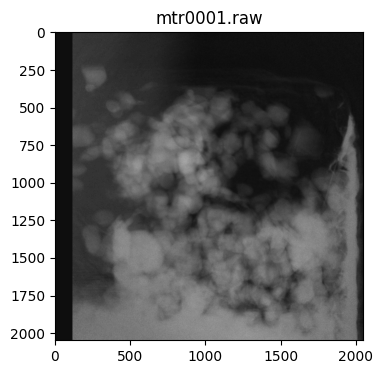

In [4]:
# Read a sample image from dataset, normalize, and display
path_dir = "data/raw/001"
name_raw = "mtr0001.raw"
filepath = os.path.join(path_dir, name_raw)
sample = read_raw_to_img(filepath)
sample_norm = normalize_img(sample)

plt.figure(figsize=[4,4])
plt.imshow(sample_norm, cmap='gray')
plt.title(f"{name_raw}")
plt.show()

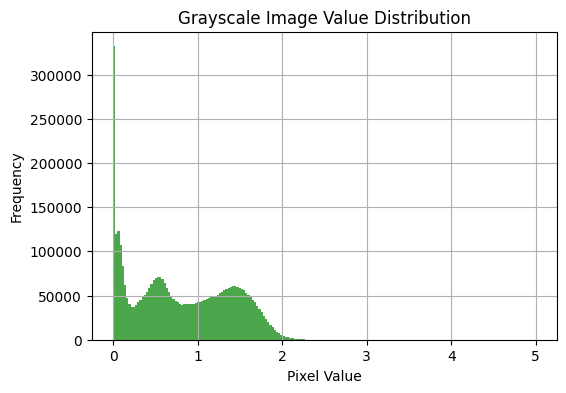

In [5]:
sample = sample.flatten()

plt.figure(figsize=(6, 4))
plt.hist(sample, bins=192, range=(0, 5), color='green', alpha=0.7)
plt.title("Grayscale Image Value Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid()
plt.show()

We draw statistics for one battery scan. One battery scan consists of 1800 x-ray images captured at 0.1 degree step from -90 to +90 degrees. Statistics are drawn on raw un-normalized data; outliers and anomalies are shown.

In [5]:
def draw_statistics(path):
    num_images = config["num_images"]
    num_attribs = config["num_attribs"]
    stat_results = np.zeros((num_images, num_attribs))

    for ii in tqdm(range(1, num_images+1)):
        # read image
        filepath = os.path.join(path, f"mtr{ii:04d}.raw")
        img = read_raw_to_img(filepath)

        # draw stastics
        stat_results[ii-1, 0] = np.min(img)                 # min
        stat_results[ii-1, 1] = np.max(img)                 # max
        stat_results[ii-1, 2] = np.mean(img)                # mean
        stat_results[ii-1, 3] = np.var(img)                 # variance
        stat_results[ii-1, 4] = np.sum(np.abs(img))         # absolute sum
        stat_results[ii-1, 5] = np.sum(img == 0) / len(img) # non-data region

        # entropy
        img = normalize_img(img)
        prob, _ = np.histogram(img, bins=256)
        prob = prob / np.sum(prob)
        entropy = -np.sum(prob * np.log(prob + 1e-10))
        stat_results[ii-1, 6] = entropy

    return stat_results

In [ ]:
stat_results = draw_statistics(path_dir)

In [6]:
def mean_max_min(path):
    num_images = config["num_images"]
    mean_values = []
    max_values = []
    min_values = []

    for ii in tqdm(range(1, num_images+1)):
        filepath = os.path.join(path, f"mtr{ii:04d}.raw")
        img = read_raw_to_img(filepath)
        
        mean_values.append(np.mean(img))
        max_values.append(np.max(img))
        min_values.append(np.min(img))
    
    return mean_values, max_values, min_values

mean_values, max_values, min_values = mean_max_min(path_dir)

100%|██████████| 1800/1800 [01:35<00:00, 18.88it/s]


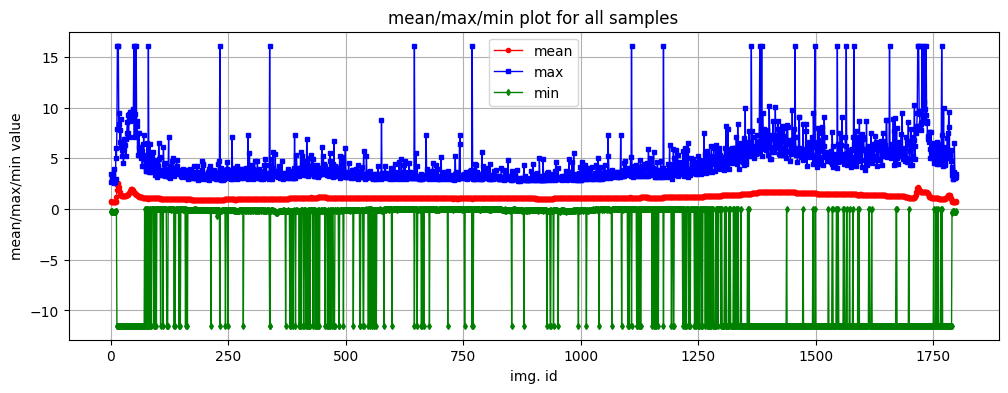

In [7]:
plt.figure(figsize=(12, 4))
plt.plot(mean_values, label='mean', color='red', marker='o', markersize=3, linewidth=1)
plt.plot(max_values, label='max', color='blue', marker='s', markersize=3, linewidth=1)
plt.plot(min_values, label='min', color='green', marker='d', markersize=3, linewidth=1)
plt.title('mean/max/min plot for all samples')
plt.xlabel('img. id')
plt.ylabel('mean/max/min value')
plt.legend()
plt.grid()
plt.show()

In [7]:
def visualize_statistics(stat_results):
    num_images = config["num_images"]
    titles = config["titles"]
    x_axis = np.arange(1, num_images+1)

    plt.figure(figsize=(15, 10))
    for i in range(7):
        plt.subplot(3, 3, i+1)
        plt.scatter(x_axis, stat_results[:, i], s=8, marker='o', c='green')
        plt.title(titles[i])
        plt.grid()
    
    plt.tight_layout()
    plt.show()

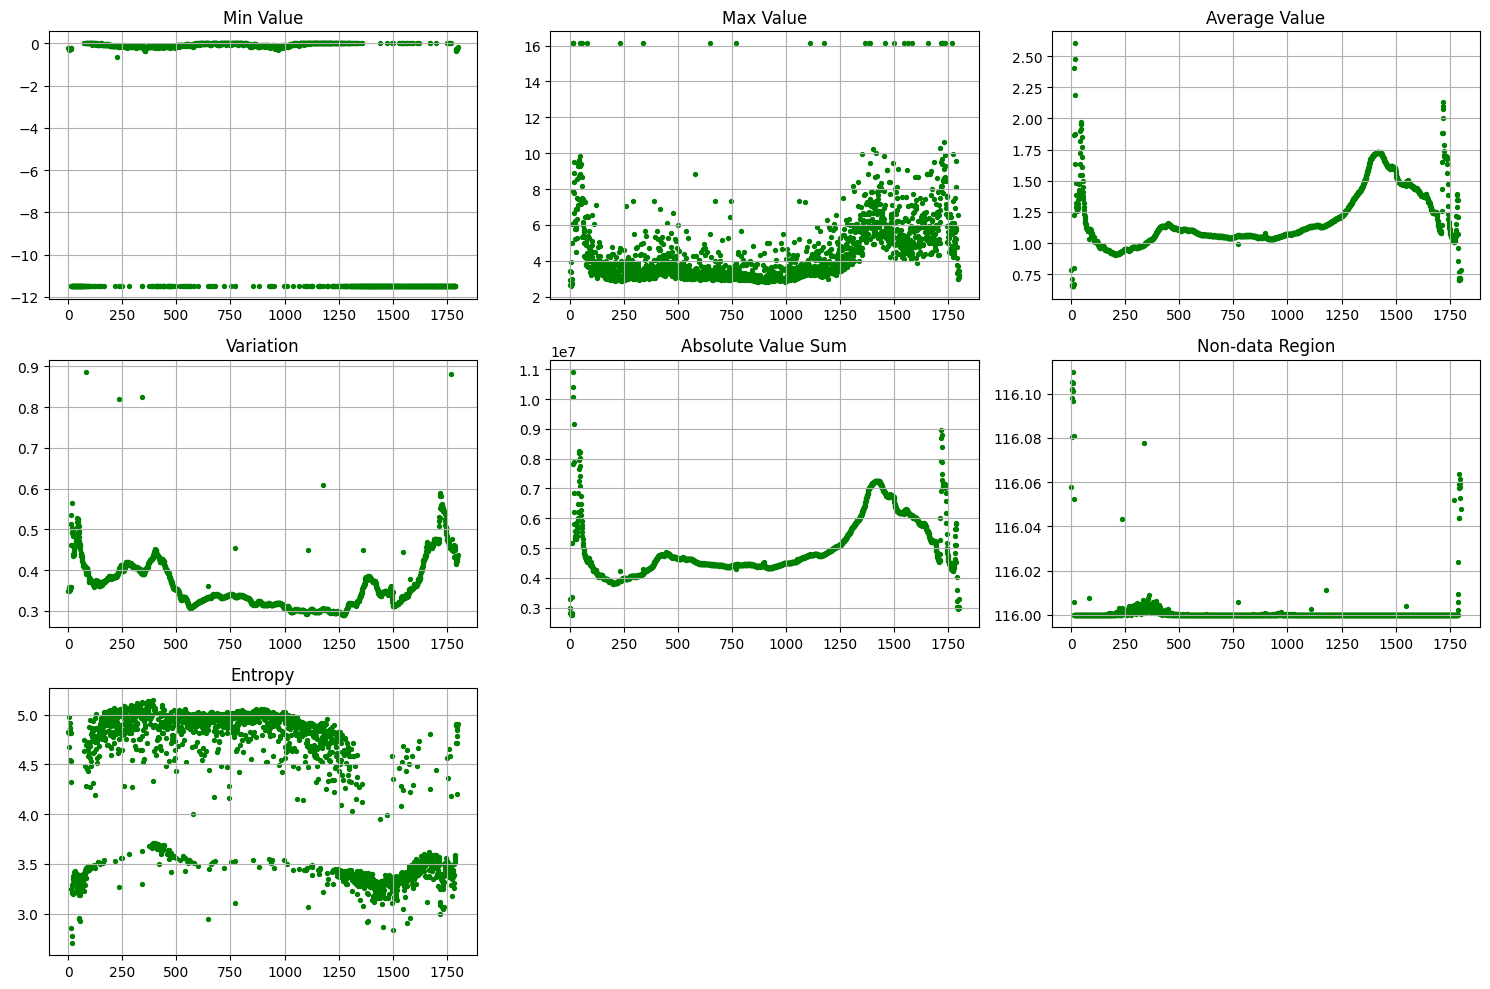

In [9]:
visualize_statistics(stat_results)

## **Clamp effects**

We inspect whether removing (clamping) outliers before normalization leads to better image quality. We perform our experiment on a subset of the train set. Images are also resized.

In [7]:
def load_dataset(path, step=10):
    """Load images from directory, resize to img_size
    Return:     images, type numpy, shape (batch, height, width)
    """
    num_images = config["num_images"]
    img_size = config["img_size"]
    num_sub_images = num_images // step
    images = np.zeros((num_sub_images, img_size[0], img_size[1]))

    for i, idx in enumerate(tqdm(range(1, num_images+1, step))):
        filepath = os.path.join(path, f"mtr{idx:04d}.raw")
        img = read_raw_to_img(filepath)
        img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
        images[i] = img

    return images

In [13]:
images = load_dataset(path_dir)
print(f"Images loaded with shape {images.shape}")

100%|██████████| 180/180 [00:00<00:00, 188.53it/s]

Images loaded with shape (180, 256, 256)


Here we take our batch of raw images and simply normalize between 0-1.

In [14]:
num_subset_images = images.shape[0]
img_height, img_width = config["img_size"]
norm_images = np.zeros((num_subset_images, img_height, img_width))

for i in tqdm(range(num_subset_images)):
    cloned_image = images[i].copy()
    norm_images[i] = normalize_img(cloned_image)

print(f"Normalized images with shape {norm_images.shape}")

100%|██████████| 180/180 [00:00<00:00, 1611.21it/s]

Normalized images with shape (180, 256, 256)


Here we take our batch of raw images, **clamp** between specified range, and normalize.

In [15]:
clamp_norm_images = np.zeros((num_subset_images, img_height, img_width))

for i in tqdm(range(num_subset_images)):
    cloned_image = images[i].copy()
    cloned_image = clamp_img(cloned_image)
    clamp_norm_images[i] = normalize_img(cloned_image)

print(f"Clamped+Normalized images with shape {clamp_norm_images.shape}")

100%|██████████| 180/180 [00:00<00:00, 1299.96it/s]

Clamped+Normalized images with shape (180, 256, 256)


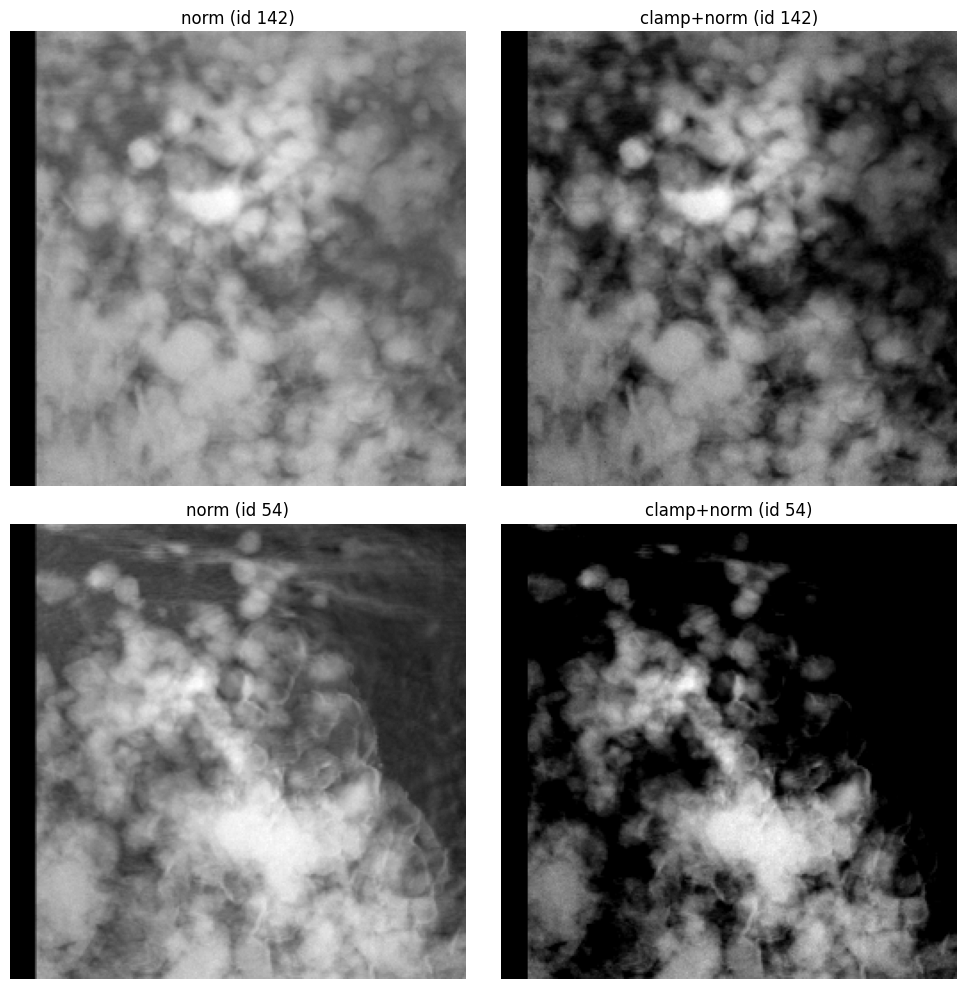

In [19]:
def show_side_by_side(set1, set2, title1, title2, num_images, to_display=2):
    rand_idx = np.random.choice(num_images, to_display, replace=False)
    rand_set1 = set1[rand_idx]
    rand_set2 = set2[rand_idx]

    fig, axes = plt.subplots(to_display, 2, figsize=(10, 10))
    for i in range(to_display):
        axes[i, 0].imshow(rand_set1[i], cmap='gray')
        axes[i, 0].set_title(f'{title1} (id {rand_idx[i]})')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(rand_set2[i], cmap='gray')
        axes[i, 1].set_title(f'{title2} (id {rand_idx[i]})')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

show_side_by_side(norm_images, clamp_norm_images, "norm", "clamp+norm", num_subset_images)

Due to particles appearing in foreground, we select a limited range of projections, i.e. from 60 to 110.

In [91]:
idx_start = 0
idx_end = 180

clamp_norm_images_subset = clamp_norm_images[idx_start:idx_end]

## **Center cropping**
We select the center crop of the images, with size 128x128

In [18]:
print(f"Original shape: {clamp_norm_images.shape}")

crop_size = 128
start_x = (256 - crop_size) // 2
start_y = (256 - crop_size) // 2

cropped_images = clamp_norm_images[:, start_x:start_x + crop_size, start_y:start_y + crop_size]
print(f"Cropped shape: {cropped_images.shape}")


Original shape: (180, 256, 256)
Cropped shape: (180, 128, 128)


## **Save to JPG**

In this section, we gather our preprocessed images and save as PNG format on hard disk.

In [21]:
#final_images = cropped_images
final_images = clamp_norm_images
print(f"final images have shape {final_images.shape}, max is {final_images.max()}, min is {final_images.min()}")

final images have shape (180, 256, 256), max is 1.0, min is 0.0


In [22]:
def save_to_disk(path, images):
    num_images = images.shape[0]

    for i in tqdm(range(num_images)):
        img_path = os.path.join(path, f"id_{i}.jpg")
        img = (images[i] * 255).astype(np.uint8)
        cv2.imwrite(img_path, img)

    print(f"Images saves in {path}.")

In [23]:
save_dir = "data/denoised/001_all_clamp_1_6"
save_to_disk(save_dir, final_images)

100%|██████████| 180/180 [00:00<00:00, 968.47it/s]

Images saves in data/denoised/001_all_clamp_1_4_crop_128.


Save projections and angles to disk as `npz` format.

In [24]:
angles_degrees = np.arange(0, 180, 1) # shape: (180,)
angles_radians = np.radians(angles_degrees)

save_dir = "data/npz"
filename = "projs_angles.npz"
np.savez(os.path.join(save_dir, filename),
         projs=final_images,
         angles=angles_radians)

print(f"Saved projections and angles to {save_dir}/{filename}")

Saved projections and angles to data/npz/projs_angles.npz


Load saved data (debug)

In [25]:
data = np.load(os.path.join(save_dir, filename))

projs_loaded = data["projs"]
angles_loaded = data["angles"]

print(projs_loaded.shape)
print(angles_loaded.shape)

(180, 256, 256)
(180,)
